In [65]:
import math
import numpy as np
import torch
import gpytorch
from gpytorch.kernels import GridInterpolationKernel as SKI
from gpytorch.kernels import SpectralMixtureKernel as SM
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from matplotlib import pyplot as plt
import matplotlib.image as img
from tqdm import tqdm
from gp import * 
from scipy.misc import imresize,imsave
import copy
%matplotlib inline
%load_ext autoreload
%autoreload 2
device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
def prep_training_img_sr(path: str) -> (torch.tensor, 
        torch.tensor, torch.tensor):
    """
    prepare the training image for super resolution
    :param path: path to the test image
    :param first_coord_crop: (start, end) the start and end of the first coordinate of the cropping area
    :param second_coord_crop: ... second coordinate ...
    : return : (1) train_x
               (2) train_y
               (3) test_x
               (4) occulated image
    """
    # prepare the training image
    
    training_img = img.imread(path)
    scaled_down_img = training_img[::2,::2,:]

    w, l, _ = training_img.shape
    train_x_first_coord = np.repeat(np.arange(0,w,2), int(l/2))
    train_x_second_coord = np.tile(np.arange(0,l,2), int(w/2))
    test_x_first_coord = np.concatenate((np.repeat(np.arange(1,w,2), int(l/2)),
                                        np.repeat(np.arange(w), int(l/2))))
    test_x_second_coord = np.concatenate((np.tile(np.arange(0,l,2), int(w/2)),
                                         np.tile(np.arange(1,l,2), int(w))))
       
    train_x = np.stack((train_x_first_coord, train_x_second_coord)).T
    test_x = np.stack((test_x_first_coord, test_x_second_coord)).T


    # train_y_rgb
    train_y_rgb = (training_img[train_x[:, 0], train_x[:, 1], 0], 
                   training_img[train_x[:, 0], train_x[:, 1], 1],
                   training_img[train_x[:, 0], train_x[:, 1], 2])

    # convert x to float, and all to tensor
    train_y_rgb = list(map(lambda x: torch.tensor(x).float().to(device), train_y_rgb))
    train_x = torch.tensor(train_x).float().to(device)
    test_x = torch.tensor(test_x).float().to(device)
    return train_x, train_y_rgb, test_x, training_img, scaled_down_img

In [54]:
path="images/lena512color.tiff"
train_x, train_y_rgb, test_x, training_img,scaled_down_img = prep_training_img_sr(path)

In [57]:
def train_super_resolution(train_x,train_y_rgb,kernel = 'rbf',ep = 200, nu = ''):  
    likelihood_r, likelihood_g, likelihood_b = GaussianLikelihood(), GaussianLikelihood(), GaussianLikelihood()
    if kernel =='matern':
        model_r = GPModel(train_x, train_y_rgb[0], likelihood_r ,kernel = kernel, nu = nu).to(device)
        model_g = GPModel(train_x, train_y_rgb[1], likelihood_g ,kernel = kernel, nu = nu).to(device)
        model_b = GPModel(train_x, train_y_rgb[2], likelihood_b ,kernel = kernel, nu = nu).to(device)
    elif  kernel =='rbf':
        model_r = GPModel(train_x, train_y_rgb[0], likelihood_r ,kernel = kernel).to(device)
        model_g = GPModel(train_x, train_y_rgb[1], likelihood_g ,kernel = kernel).to(device)
        model_b = GPModel(train_x, train_y_rgb[2], likelihood_b ,kernel = kernel).to(device)
        
    optimizer_r = torch.optim.Adam([{"params":model_r.parameters()}], lr=0.1)
    optimizer_g = torch.optim.Adam([{"params":model_g.parameters()}], lr=0.1)
    optimizer_b = torch.optim.Adam([{"params":model_b.parameters()}], lr=0.1)
    train(model_r, likelihood_r, optimizer_r, ep, train_x, train_y_rgb[0])
    train(model_g, likelihood_g, optimizer_g, ep, train_x, train_y_rgb[1])
    train(model_b, likelihood_b, optimizer_b, ep, train_x, train_y_rgb[2])
    torch.save(model_r.state_dict(), 'models/model_r_sr_' + kernel + str(nu))
    torch.save(model_g.state_dict(), 'models/model_g_sr_' + kernel + str(nu))
    torch.save(model_b.state_dict(), 'models/model_b_sr_' + kernel + str(nu))
    return model_r,model_g,model_b

In [ ]:
for nu in [0.5,1.5,2.5]:
    print(nu)
    train_super_resolution(train_x,train_y_rgb,kernel = 'matern',ep = 200, nu = nu)

0.5
Iter 1/200 - Loss: 13292.805
Iter 2/200 - Loss: 11674.480
Iter 3/200 - Loss: 10221.628
Iter 4/200 - Loss: 8924.668
Iter 5/200 - Loss: 7773.484
Iter 6/200 - Loss: 6757.593
Iter 7/200 - Loss: 5866.279
Iter 8/200 - Loss: 5088.746
Iter 9/200 - Loss: 4414.228
Iter 10/200 - Loss: 3832.114
Iter 11/200 - Loss: 3332.077
Iter 12/200 - Loss: 2904.234
Iter 13/200 - Loss: 2539.286
Iter 14/200 - Loss: 2228.646
Iter 15/200 - Loss: 1964.534
Iter 16/200 - Loss: 1740.020
Iter 17/200 - Loss: 1549.036
Iter 18/200 - Loss: 1386.333
Iter 19/200 - Loss: 1247.424
Iter 20/200 - Loss: 1128.512
Iter 21/200 - Loss: 1026.398
Iter 22/200 - Loss: 938.408
Iter 23/200 - Loss: 862.308
Iter 24/200 - Loss: 796.242
Iter 25/200 - Loss: 738.660
Iter 26/200 - Loss: 688.276
Iter 27/200 - Loss: 644.016
Iter 28/200 - Loss: 604.984
Iter 29/200 - Loss: 570.431
Iter 30/200 - Loss: 539.728
Iter 31/200 - Loss: 512.345
Iter 32/200 - Loss: 487.837
Iter 33/200 - Loss: 465.823
Iter 34/200 - Loss: 445.986
Iter 35/200 - Loss: 428.050
I

Iter 91/200 - Loss: 77.414
Iter 92/200 - Loss: 76.887
Iter 93/200 - Loss: 76.366
Iter 94/200 - Loss: 75.853
Iter 95/200 - Loss: 75.351
Iter 96/200 - Loss: 74.856
Iter 97/200 - Loss: 74.369
Iter 98/200 - Loss: 73.890
Iter 99/200 - Loss: 73.417
Iter 100/200 - Loss: 72.953
Iter 101/200 - Loss: 72.495
Iter 102/200 - Loss: 72.046
Iter 103/200 - Loss: 71.601
Iter 104/200 - Loss: 71.165
Iter 105/200 - Loss: 70.734
Iter 106/200 - Loss: 70.310
Iter 107/200 - Loss: 69.891
Iter 108/200 - Loss: 69.478
Iter 109/200 - Loss: 69.072
Iter 110/200 - Loss: 68.671
Iter 111/200 - Loss: 68.275
Iter 112/200 - Loss: 67.886
Iter 113/200 - Loss: 67.500
Iter 114/200 - Loss: 67.121
Iter 115/200 - Loss: 66.746
Iter 116/200 - Loss: 66.377
Iter 117/200 - Loss: 66.014
Iter 118/200 - Loss: 65.653
Iter 119/200 - Loss: 65.299
Iter 120/200 - Loss: 64.948
Iter 121/200 - Loss: 64.603
Iter 122/200 - Loss: 64.260
Iter 123/200 - Loss: 63.922
Iter 124/200 - Loss: 63.590
Iter 125/200 - Loss: 63.261
Iter 126/200 - Loss: 62.936
I

Iter 186/200 - Loss: 44.863
Iter 187/200 - Loss: 44.700
Iter 188/200 - Loss: 44.540
Iter 189/200 - Loss: 44.383
Iter 190/200 - Loss: 44.223
Iter 191/200 - Loss: 44.067
Iter 192/200 - Loss: 43.913
Iter 193/200 - Loss: 43.761
Iter 194/200 - Loss: 43.608
Iter 195/200 - Loss: 43.457
Iter 196/200 - Loss: 43.307
Iter 197/200 - Loss: 43.158
Iter 198/200 - Loss: 43.013
Iter 199/200 - Loss: 42.867
Iter 200/200 - Loss: 42.722
1.5
Iter 1/200 - Loss: 13700.083
Iter 2/200 - Loss: 12054.470
Iter 3/200 - Loss: 10557.713
Iter 4/200 - Loss: 9204.034


In [60]:
# torch.save(model_r.state_dict(), 'model_r_sr_ma')
# torch.save(model_g.state_dict(), 'model_g_sr_ma')
# torch.save(model_b.state_dict(), 'model_b_sr_ma')
# model_r.load_state_dict(torch.load('model_r_sr_rbf'))
# model_g.load_state_dict(torch.load('model_g_sr_rbf'))
# model_b.load_state_dict(torch.load('model_b_sr_rbf'))


In [68]:
# Test: prediction on the test set
def evaluate_super_resolution(model_r,model_g,model_b,test_x,scaled_down_img,training_img,nu):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_r = test(model_r, likelihood_r, test_x).mean.cpu().numpy()
        pred_g = test(model_g, likelihood_g, test_x).mean.cpu().numpy()
        pred_b = test(model_b, likelihood_b, test_x).mean.cpu().numpy()
    test_x_rs = test_x.reshape(-1,2).cpu().numpy().astype('int')
    ground_truths = training_img[test_x_rs[:, 0], test_x_rs[:, 1], :]
    ## show interploated image
    img_sr = copy.deepcopy(training_img)
    img_sr[test_x_rs[:, 0], test_x_rs[:, 1], 0] = pred_r
    img_sr[test_x_rs[:, 0], test_x_rs[:, 1], 1] = pred_g
    img_sr[test_x_rs[:, 0], test_x_rs[:, 1], 2] = pred_b
    imsave('images/supers_resolution_nu' + str(nu) + '.png', img_sr)
    
    # Bilinear interpolation
#     img_bilinear = imresize(scaled_down_img,200,'bilinear')
#     img_bicubic = imresize(scaled_down_img,200,'bicubic')
#     mses = []
#     for test_img in [img_sr, img_bilinear, img_bicubic]:
#         mses.append(mse(training_img,test_img))
    return mse(training_img,img_sr)

In [71]:
kernel = 'matern'
all_mse = []
for nu in [0.5,1.5,2.5]:
    print(nu)
    model_r = GPModel(train_x, train_y_rgb[0], likelihood_r ,kernel = kernel, nu = nu).to(device)
    model_g = GPModel(train_x, train_y_rgb[1], likelihood_g ,kernel = kernel, nu = nu).to(device)
    model_b = GPModel(train_x, train_y_rgb[2], likelihood_b ,kernel = kernel, nu = nu).to(device)
    model_r.load_state_dict(torch.load('models/model_r_sr_' + kernel + str(nu)))
    model_g.load_state_dict(torch.load('models/model_r_sr_' + kernel + str(nu)))
    model_b.load_state_dict(torch.load('models/model_r_sr_' + kernel + str(nu)))
    mse_nu = evaluate_super_resolution(model_r,model_g,model_b,test_x,scaled_down_img,training_img,nu)
    print(mse_nu)
    all_mse.append(mse_nu)

0.5


/home/caleb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


28.173683166503906
1.5
27.97264226277669
2.5
28.219212849934895


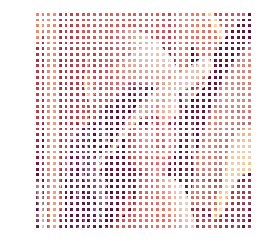

/home/caleb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys
/home/caleb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/home/caleb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':


In [82]:
img_sr = copy.deepcopy(training_img)
img_sr[test_x_rs[:, 0], test_x_rs[:, 1], 0] = 255
img_sr[test_x_rs[:, 0], test_x_rs[:, 1], 1] = 255
img_sr[test_x_rs[:, 0], test_x_rs[:, 1], 2] = 255
scaled_down_img = training_img[::2,::2,:]
plot_img(img_sr)
imsave('super_resolution_scaled_down.png',scaled_down_img)
imsave('super_resolution_occluded.png',img_sr)
imsave('super_resolution_original.png',training_img)


In [80]:
print(scaled_down_img[0,:,0])
print(training_img[0,:,0])

[226 223 226 228 227 228 223 223 221 222 223 224 218 223 221 220 225 226
 225 229 231 230 234 233 237 234 234 233 227 219 203 187 169 158 155 166
 166 169 174 175 177 177 175 173 177 177 182 178 176 178 173 179 177 182
 187 194 190 195 195 192 203 206 201 202 205 209 204 202 200 204 207 203
 205 203 202 204 205 204 205 206 206 210 207 207 210 214 211 208 209 204
 207 204 208 206 203 204 206 208 211 211 208 204 209 203 202 207 203 202
 201 206 205 205 202 201 205 201 206 208 210 209 209 208 209 207 206 206
 205 205 208 207 203 200 209 202 209 208 202 206 200 208 205 199 203 203
 199 206 204 202 198 201 203 200 193 193 195 190 181 178 179 170 180 189
 197 208 212 214 215 222 221 223 218 221 219 220 218 223 221 218 222 221
 220 224 222 222 221 222 223 221 224 223 222 221 223 221 221 222 220 221
 220 221 216 224 237 244 248 248 250 253 252 247 231 207 168 165 165 172
 180 185 183 184 187 192 186 191 191 186 187 188 193 192 190 190 185 197
 196 194 197 191 195 189 196 194 196 192 199 196 19

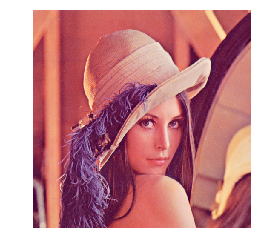

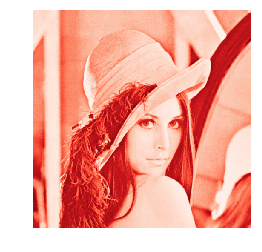

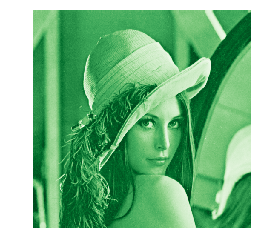

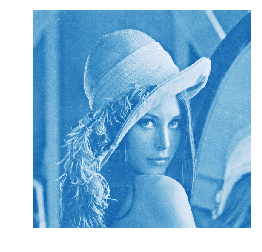

In [70]:
def mse(img1,img2):
    return np.mean(np.power(img1-img2,2))

#Original Image
plot_img(training_img)
plot_img(training_img[:,:,0], cmap=plt.cm.Reds_r)
plot_img(training_img[:,:,1], cmap=plt.cm.Greens_r)
plot_img(training_img[:,:,2], cmap=plt.cm.Blues_r)
## interpolated image

(196608, 2)


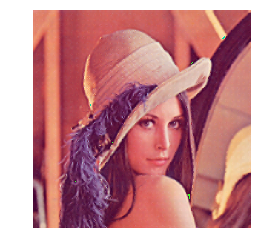

(512, 512, 3)
evaluating
29.454973856608074
evaluating
29.82269287109375
evaluating
30.489325205485027


/home/caleb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':
/home/caleb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  del sys.path[0]


In [ ]:
# from scipy import interpolate
# train_x_rs = train_x.cpu().numpy().reshape(-1,2)
# z = np.array([x.cpu().numpy() for x in train_y_rgb]).T
# x_new = y_new = np.arange(512)

In [ ]:
# new_image = []
# for i in range(3):
#     f = interpolate.interp2d(train_x_rs[:,0], train_x_rs[:,1], z[:,0], kind='cubic')
#     new_image.append(f(x_new,y_new))

In [ ]:
# new_image = np.array(new_image).T
# plot_img(new_img)